The goal is to identify which customers contribute the most financially.

In [34]:
#%load_ext nb_black

# Library to suppress warnings or deprecation notes
!pip install scikit-learn
!pip install geopy
!pip install folium
!pip install pdfkit
!pip install geopandas

import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.manifold import TSNE
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import datetime
from sklearn.impute import KNNImputer
import plotly.express as px
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy import stats
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.metrics import make_scorer, silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import GridSearchCV

In [35]:
df_value_based = pd.read_csv("df_ready_for_clustering.csv")
df_value_based.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,HasBonus,TotalFlights,sr_jan,sr_feb,...,CustomerSegment_Moderate traveler and high redeemed,CustomerSegment_Moderate traveler and low redeemed,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single,LoyaltyStatus_Nova,LoyaltyStatus_Star
0,0.011660,0.200000,0.053732,0.101416,0.497569,0.053931,0.0,0.655977,0.026667,0.040000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.016634,0.224490,0.031560,0.071096,0.232192,0.031779,0.0,0.714286,0.077551,0.024490,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.003408,0.241706,0.046686,0.347041,0.587235,0.046867,0.0,0.615160,0.094787,0.000000,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.010644,0.157407,0.076975,0.111097,0.361054,0.077074,0.0,0.314869,0.000000,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.007622,0.276243,0.054122,0.155144,0.491619,0.054280,0.0,0.527697,0.022099,0.027624,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
df_value_based.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'HasBonus', 'TotalFlights', 'sr_jan', 'sr_feb',
       'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep',
       'sr_oct', 'sr_nov', 'sr_dec', 'Province or State', 'Income',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value',
       'CustomerSegment_Low traveler and low redeemed',
       'CustomerSegment_Moderate traveler and high redeemed',
       'CustomerSegment_Moderate traveler and low redeemed',
       'Education_College', 'Education_Doctor',
       'Education_High School or Below', 'Education_Master',
       'Marital Status_Married', 'Marital Status_Single', 'LoyaltyStatus_Nova',
       'LoyaltyStatus_Star'],
      dtype='object')

In [37]:
value_features = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint',
    'AvgDistancePerFlight',
    'FlightsWithCompanionsRatio',
    'TotalFlights',

    'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun',
    'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec'
]

df_value_based = df_value_based[value_features]


# Hierarchical Clustering 

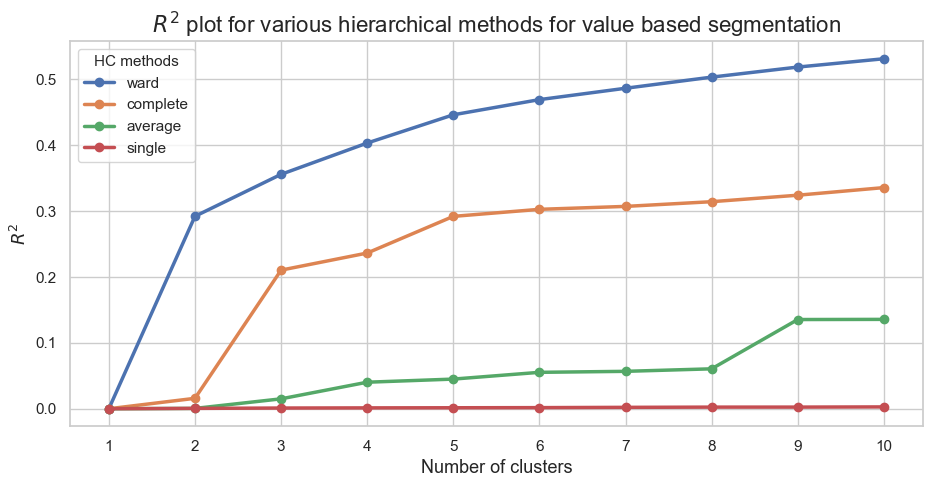

In [38]:

def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = df_value_based.columns.tolist()  # your numeric features for clustering
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=df_value_based[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for value based segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()


Ward linkage is the best method, since it gets the best r2 across all clusters.

In [39]:
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(df_value_based, method="ward") 

In [40]:
linkage_matrix.shape

# Column	Meaning
# 0	        Index of first cluster merged
# 1	        Index of second cluster merged
# 2	        Distance between them at merge (height in dendrogram)
# 3	        Number of original observations contained in the new cluster

(16573, 4)

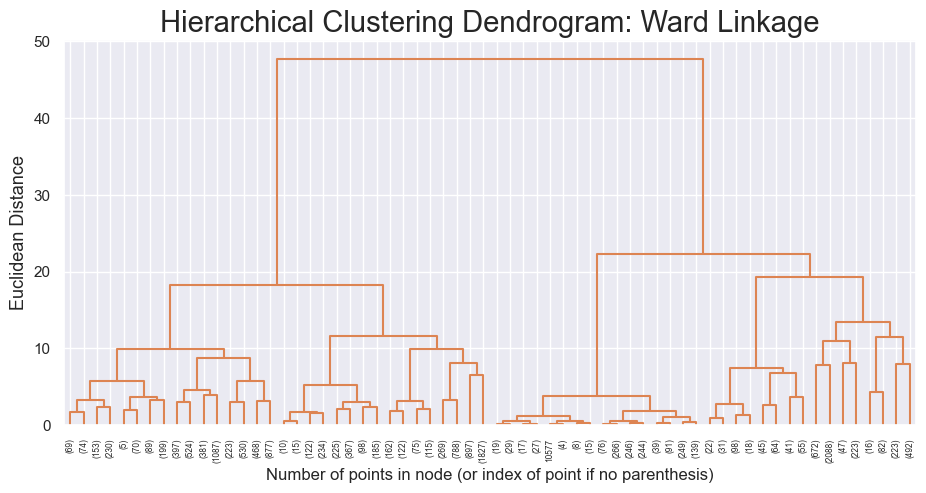

In [41]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='k')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

let's try with nclusters = 2 and nclusters=3

In [60]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 2
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels2 = hclust.fit_predict(df_value_based)

In [61]:
df_concat = pd.concat([
    df_value_based, 
    pd.Series(hc_labels2, name='labels', index=df_value_based.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1
Customer Lifetime Value,0.069756,0.077392
UnredeemedPoints,0.098486,0.422047
PointsRedeemedRatio,0.008300,0.008834
KMPerRedeemedPoint,0.033227,0.148070
AvgDistancePerFlight,0.040710,0.048159
FlightsWithCompanionsRatio,0.198239,0.244411
TotalFlights,0.132516,0.545199
sr_jan,0.033844,0.060289
sr_feb,0.031658,0.059854
sr_mar,0.040778,0.080464


In [62]:
# Features used for clustering
X = df_value_based

# Compute metrics
silhouette = silhouette_score(X, hc_labels2)
calinski_harabasz = calinski_harabasz_score(X, hc_labels2)
davies_bouldin = davies_bouldin_score(X, hc_labels2)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.31248984782357403
Calinski-Harabasz Index: 6830.858407045421
Davies-Bouldin Index: 1.4552396123464046


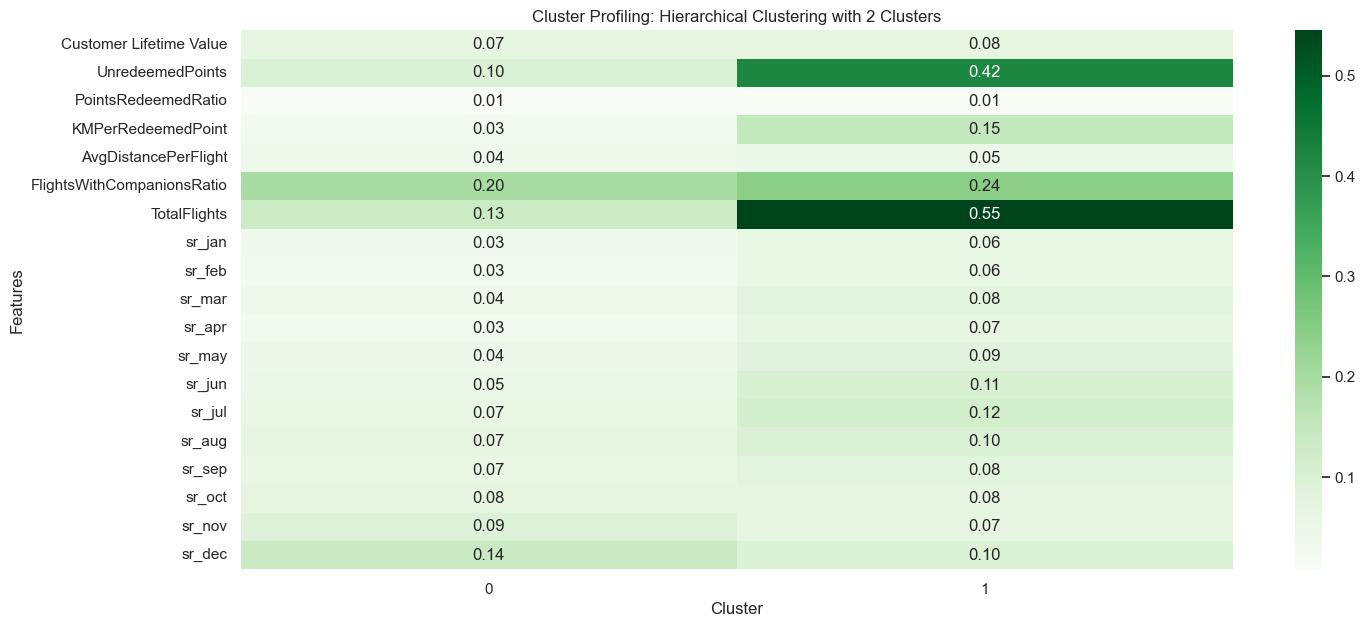

In [63]:
cluster_means = df_concat.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(cluster_means, cmap="Greens", annot=True, fmt=".2f")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 2 Clusters")
plt.show()


In [64]:
# 3 cluster solution

linkage = "ward" 
distance = "euclidean" 
n_clusters = 3
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels3 = hclust.fit_predict(df_value_based)

In [65]:
df_concat = pd.concat([
    df_value_based, 
    pd.Series(hc_labels3, name='labels', index=df_value_based.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2
Customer Lifetime Value,0.066896,0.077392,0.077961
UnredeemedPoints,0.132805,0.422047,0.000037
PointsRedeemedRatio,0.011193,0.008834,0.000000
KMPerRedeemedPoint,0.044809,0.148070,0.000000
AvgDistancePerFlight,0.054902,0.048159,0.000000
FlightsWithCompanionsRatio,0.267343,0.244411,0.000000
TotalFlights,0.178710,0.545199,0.000000
sr_jan,0.045641,0.060289,0.000000
sr_feb,0.042693,0.059854,0.000000
sr_mar,0.054992,0.080464,0.000000


In [66]:
# Features used for clustering
X = df_value_based

# Compute metrics
silhouette = silhouette_score(X, hc_labels3)
calinski_harabasz = calinski_harabasz_score(X, hc_labels3)
davies_bouldin = davies_bouldin_score(X, hc_labels3)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.31443459945015734
Calinski-Harabasz Index: 4570.3453472573165
Davies-Bouldin Index: 1.4996739828893333


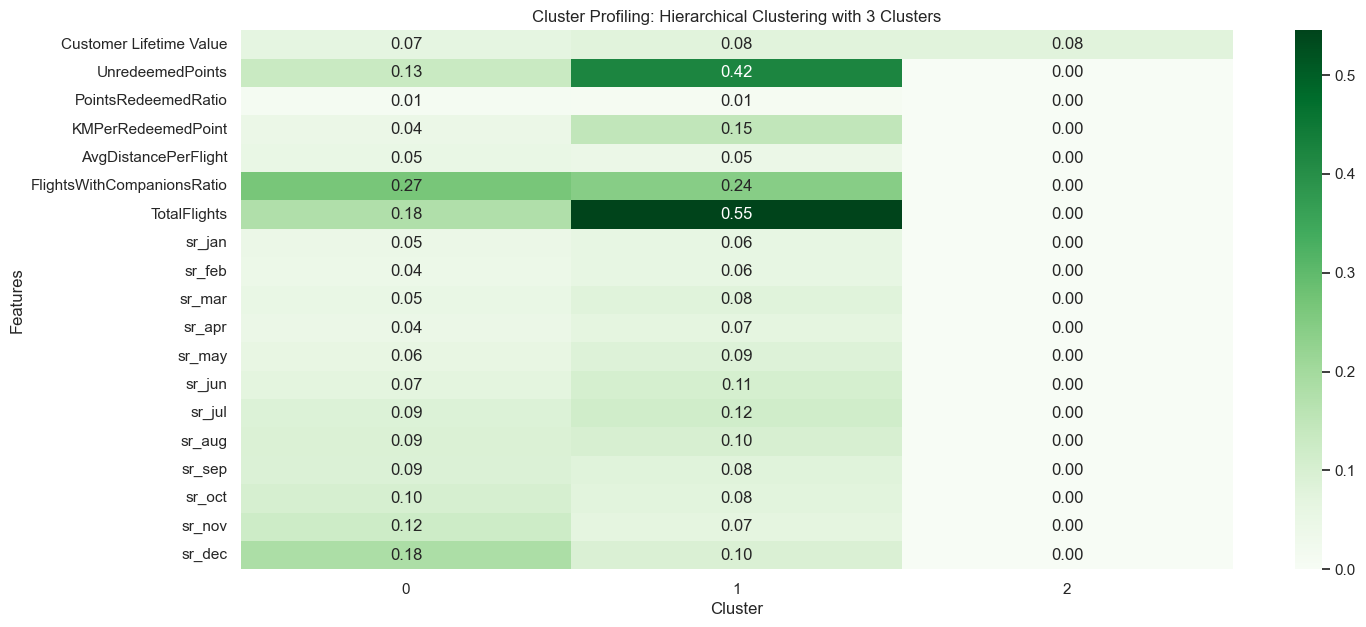

In [67]:
cluster_means = df_concat.groupby('labels')[value_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(cluster_means, cmap="Greens", annot=True, fmt=".2f")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 3 Clusters")
plt.show()

In [68]:
## See crosstab of 3 vs 2

pd.crosstab(
    pd.Series(hc_labels3, name='hc3_labels', index=df_value_based.index),
    pd.Series(hc_labels2, name='hc2_labels', index=df_value_based.index),
    )

hc2_labels,0,1
hc3_labels,,
0,4217,0
1,0,10887
2,1470,0


### Conclusion (this will be after hierarchical and moe techiques)
    
    K-Means with 4 clusters outperforms Hierarchical clustering with 4 clusters in all three metrics: Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index. Thus, K-Means with 4 clusters does improve the clustering results compared to Hierarchical clustering with 4 clusters.

    In addition, in terms of insights for customer segmentation analysis and marketing strategies, the result of the K-means with 4 clusters reveals much more interesting patterns, and for this reason, it will be used.


